This notebook (04) builds models for binary classification with the datasets saved from notebook 03.

A base model is built from scratch using tensorflow keras API. Transfer learning is applied with two different pre-trained models.

Accuray and confusion matrics is used as the evaluation metrics.

Some of the functions called in this notebook are defined in 'mymodules.py' file.

In [ ]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import os

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")


TF version: 2.9.2
TF Hub version: 0.12.0
GPU available


Link to Google drive.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('./drive/MyDrive/dog_breeds_classification/notebooks')
import mymodules

# 4 Binary classifiers

## 4.1 Load tensorflow datasets from drive. These datasets are save from notebook _03_

In [ ]:
DATA_PATH = "./drive/MyDrive/dog_breeds_classification/Images_Poodles"
OUTPUT_TFDATA_PATH = "./drive/MyDrive/dog_breeds_classification/saved_tf_datasets/"
OUTPUT_FIGURE_PATH = "./drive/MyDrive/dog_breeds_classification/output_figures/binary/"

IMAGE_SIZE = 224
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

EPOCH = 40
EPOCH_PRETRAINED = 40

In [ ]:
N_CLASSES = 1

#### Load saved tensorflow datasets



In [ ]:
!ls ./drive/MyDrive/dog_breeds_classification/saved_tf_datasets/

binary_test_ds_poodles	    binary_valid_ds_retrievers	train_ds_retrievers
binary_test_ds_retrievers   saved_models		valid_ds_poodles
binary_train_ds_poodles     test_ds_poodles		valid_ds_retrievers
binary_train_ds_retrievers  test_ds_retrievers
binary_valid_ds_poodles     train_ds_poodles


In [ ]:
train_ds = tf.data.experimental.load(OUTPUT_TFDATA_PATH + 'binary_train_ds_poodles')
valid_ds = tf.data.experimental.load(OUTPUT_TFDATA_PATH + 'binary_valid_ds_poodles')
test_ds = tf.data.experimental.load(OUTPUT_TFDATA_PATH + 'binary_test_ds_poodles')

In [ ]:
print(len(train_ds), len(valid_ds), len(test_ds))

23 4 3


In [ ]:
X_train = np.concatenate([x for x,y in train_ds], axis=0)
y_train = np.concatenate([y for x,y in train_ds], axis=0)

X_valid = np.concatenate([x for x,y in valid_ds], axis=0)
y_valid = np.concatenate([y for x,y in valid_ds], axis=0)

X_test = np.concatenate([x for x,y in test_ds], axis=0)
y_test = np.concatenate([y for x,y in test_ds], axis=0)

## 4.2 Build base models from scratch

We will:
- test 3 different archetectures
- test 3 learning rate
- pick the best model and learning rate, and apply it to the test dataset


In [ ]:
checkpoint = ModelCheckpoint('notebook_output', monitor='val_acc', mode='max')
earlystop = EarlyStopping(patience=5, monitor='val_loss')
logger = CSVLogger('notebook_logger.csv')
callbacks_list = [checkpoint, earlystop, logger]

#### Build the models

In [ ]:
# base model #1
basemodel_1 = models.Sequential()
basemodel_1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE))
basemodel_1.add(layers.Conv2D(64, (3,3), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Dropout(0.7))
basemodel_1.add(layers.Conv2D(64, (3,3), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Dropout(0.7))
basemodel_1.add(layers.Conv2D(128, (5,5), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Conv2D(128, (3,3), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Dropout(0.7))
basemodel_1.add(layers.Conv2D(128, (3,3), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Conv2D(128, (3,3), activation='relu'))
basemodel_1.add(layers.MaxPool2D((2,2)))
basemodel_1.add(layers.Flatten())
basemodel_1.add(layers.Dense(64, activation='relu'))
basemodel_1.add(layers.Dense(N_CLASSES, activation='sigmoid'))

basemodel_1.build(input_shape=INPUT_SHAPE)

#### Compile and train the model

In [ ]:
basemodel_1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

history = basemodel_1.fit(train_ds, 
                    epochs = EPOCH, 
                    batch_size=BATCH_SIZE, 
                    verbose=0,
                    validation_data=valid_ds,
                    validation_batch_size=BATCH_SIZE,
                    callbacks=callbacks_list
                    )

#### Evaluate the models

In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'basemodel_loss_accu_aug.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'basemodel_matrix_aug.png'

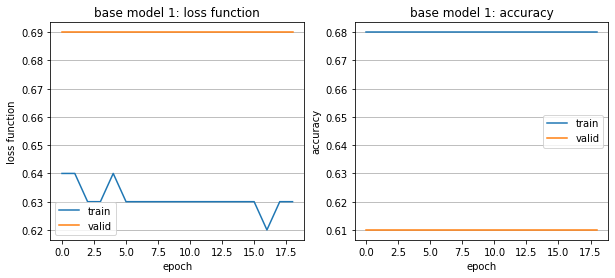

In [ ]:
mymodules.check_loss_accu('base model 1', history, figname_loss)

yes
2/2 [==============================] - 0s 45ms/step
prediction accuracy of basemodel_1
       train  valid  test
class                    
0        1.0    1.0   1.0
1        0.0    0.0   0.0


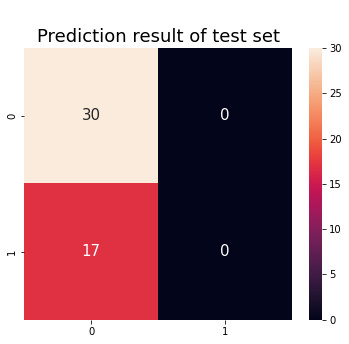

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(basemodel_1, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('basemodel_1', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set', fontsize=18)
plt.savefig(figname_matrix)

###Check accuracy for each image class. For the class that is most difficult to identify, we will build a binary classifier in notebook 04 to improve the accuracy for this particular class.

## 4.3 Transfer learning models

Import three pre-trained models from Tensorflow Hub. Use the pre-trained model as a base model and add a couple of dense layers on top of it. These models are expected to give higher accuracy comparing with the previous model built from scratch.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D

In [ ]:
PRETRAINED_MOBILENET_V3= "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
INCEPTION_V3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [ ]:
def make_model_B(base_model, nclasses):
  model = models.Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(nclasses, activation='sigmoid'))

  model.layers[0].trainable=False
  return model

In [ ]:
def make_model_C(base_model, nclasses):
  model = models.Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(nclasses, activation='sigmoid'))

  model.layers[0].trainable=False
  return model

### 4.3.1 Pretrained MOBILENET_V2 model

In [ ]:
base_model_mn = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

9406464/9406464 [==============================] - 0s 0us/step


#### Model B

In [ ]:
model_mobilenetv2_1= make_model_B(base_model_mn, N_CLASSES)
model_mobilenetv2_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_1 = model_mobilenetv2_1.fit(train_ds, 
                    epochs = EPOCH_PRETRAINED, 
                    batch_size=BATCH_SIZE, 
                    verbose=0,
                    validation_data=valid_ds)

In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_B_loss_accu.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_B_matrix.png'

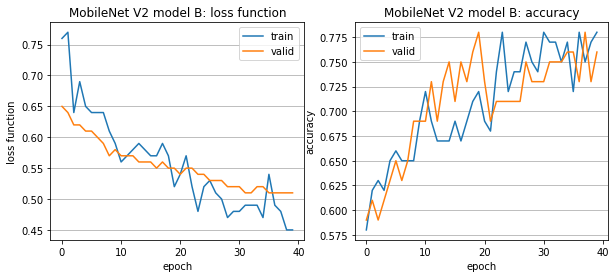

In [ ]:
mymodules.check_loss_accu('MobileNet V2 model B', history_1, figname_loss)

yes
2/2 [==============================] - 0s 35ms/step
prediction accuracy of MobileNet V2
       train  valid  test
class                    
0       0.94   0.87  0.67
1       0.90   0.60  0.53


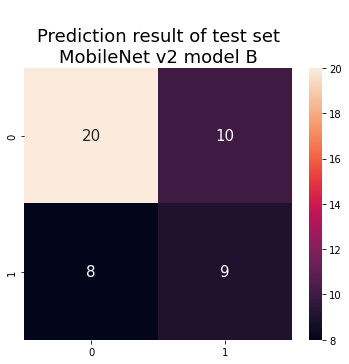

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_mobilenetv2_1, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('MobileNet V2', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nMobileNet v2 model B', fontsize=18)
plt.savefig(figname_matrix)

#### Model C

In [ ]:
model_mobilenetv2_2= make_model_C(base_model_mn, N_CLASSES)
model_mobilenetv2_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_2 = model_mobilenetv2_2.fit(train_ds, 
                    epochs = EPOCH_PRETRAINED, 
                    batch_size=BATCH_SIZE, 
                    verbose=0,
                    validation_data=valid_ds)

In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_C_loss_accu.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_C_matrix.png'

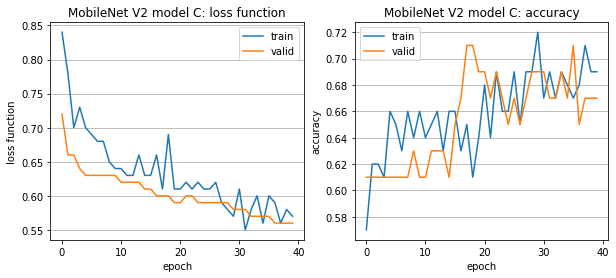

In [ ]:
mymodules.check_loss_accu('MobileNet V2 model C', history_2, figname_loss)

yes
2/2 [==============================] - 0s 38ms/step
prediction accuracy of MobileNet V2
       train  valid  test
class                    
0       0.94    0.9  0.80
1       0.54    0.3  0.24


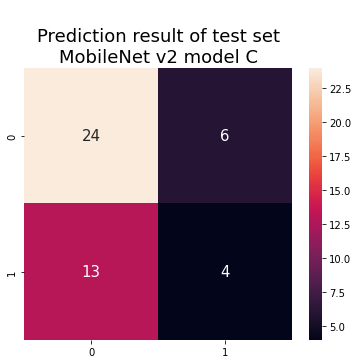

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_mobilenetv2_2, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('MobileNet V2', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nMobileNet v2 model C', fontsize=18)
plt.savefig(figname_matrix)

### 4.3.2 Pretrained INCEPTION_V3 model

In [ ]:
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

87910968/87910968 [==============================] - 3s 0us/step


#### Model B

In [ ]:
model_inceptv3_1 = make_model_B(base_model_incep, N_CLASSES)
model_inceptv3_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_1 = model_inceptv3_1.fit(train_ds, 
                    epochs = EPOCH_PRETRAINED, 
                    batch_size=BATCH_SIZE, 
                    verbose=0,
                    validation_data=valid_ds)

In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'Inception_v3_model_B_loss_accu.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'Inception_v3_model_B_matrix.png'

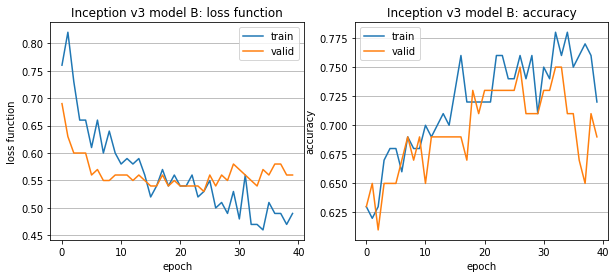

In [ ]:
mymodules.check_loss_accu('Inception v3 model B', history_1, figname_loss)

yes
2/2 [==============================] - 0s 63ms/step
prediction accuracy of Inception v3
       train  valid  test
class                    
0       0.89   0.87  0.83
1       0.81   0.40  0.71


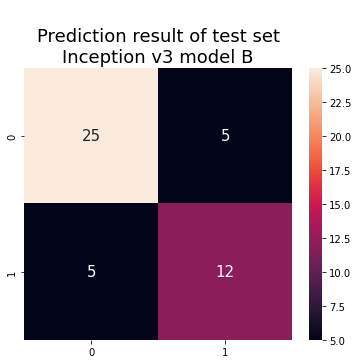

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_inceptv3_1, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('Inception v3', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nInception v3 model B', fontsize=18)
plt.savefig(figname_matrix)

#### Model C

In [ ]:
model_inceptv3_2 = make_model_C(base_model_incep, N_CLASSES)
model_inceptv3_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_2 = model_inceptv3_2.fit(train_ds, 
                    epochs = EPOCH_PRETRAINED, 
                    batch_size=BATCH_SIZE, 
                    verbose=0,
                    validation_data=valid_ds)

In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'Inception_v3_model_C_loss_accu.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'Inception_v3_model_C_matrix.png'

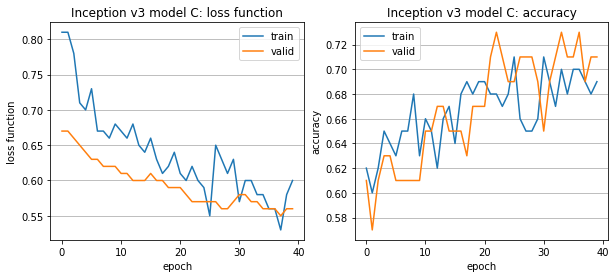

In [ ]:
mymodules.check_loss_accu('Inception v3 model C', history_2, figname_loss)

yes
2/2 [==============================] - 0s 64ms/step
prediction accuracy of Inception v3
       train  valid  test
class                    
0       0.76   0.81  0.73
1       0.78   0.55  0.71


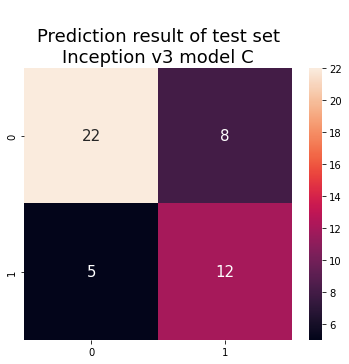

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_inceptv3_2, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('Inception v3', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nInception v3 model C', fontsize=18)
plt.savefig(figname_matrix)

## 4.4 Transfer learning, with Data Augmentation

### 4.4.1 MobileNet_V2 With data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                               rotation_range = 30,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True)
valid_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_gen.flow(X_train, y_train, shuffle=False, batch_size=BATCH_SIZE, seed=1)
valid_generator = valid_gen.flow(X_valid, y_valid, shuffle=False, batch_size=BATCH_SIZE, seed=1)

#### Model B

In [ ]:
model_mobilev2_aug1 = make_model_B(base_model_mn, N_CLASSES)
model_mobilev2_aug1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

In [ ]:
train_steps_per_epoch = X_train.shape[0]//BATCH_SIZE
valid_steps_per_epoch = X_valid.shape[0]//BATCH_SIZE

In [ ]:


history_1 = model_mobilev2_aug1.fit_generator(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_steps = valid_steps_per_epoch, 
                    validation_data = valid_generator,
                    epochs = EPOCH_PRETRAINED, 
                    verbose=0)

<ipython-input-42-cae870b4c686>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model_mobilev2_aug1.fit_generator(train_generator,


In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_B_loss_accu_aug.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_B_matrix_aug.png'

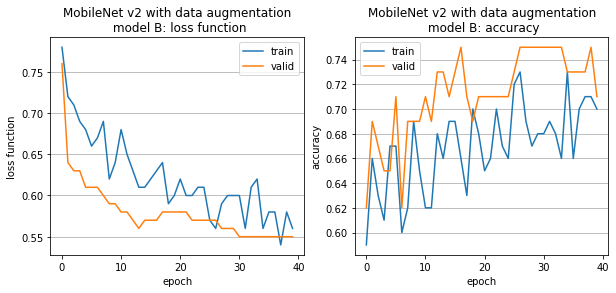

In [ ]:
mymodules.check_loss_accu('MobileNet v2 with data augmentation\n model B', history_1, figname_loss)

yes
2/2 [==============================] - 0s 34ms/step
prediction accuracy of MobileNet v2 with data augmentation
       train  valid  test
class                    
0       0.87   0.87  0.70
1       0.70   0.50  0.41


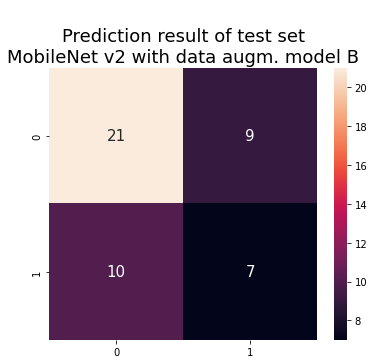

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_mobilev2_aug1, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('MobileNet v2 with data augmentation', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nMobileNet v2 with data augm. model B', fontsize=18)
plt.savefig(figname_matrix)

#### Model C

In [ ]:
model_mobilev2_aug2 = make_model_C(base_model_mn, N_CLASSES)
model_mobilev2_aug2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_2 = model_mobilev2_aug2.fit_generator(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_steps = valid_steps_per_epoch, 
                    validation_data = valid_generator,
                    epochs = EPOCH_PRETRAINED, 
                    verbose=0)

<ipython-input-46-3cbbd1f6d907>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_mobilev2_aug2.fit_generator(train_generator,


In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_C_loss_accu_aug.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'MobileNet_v2_model_C_matrix_aug.png'

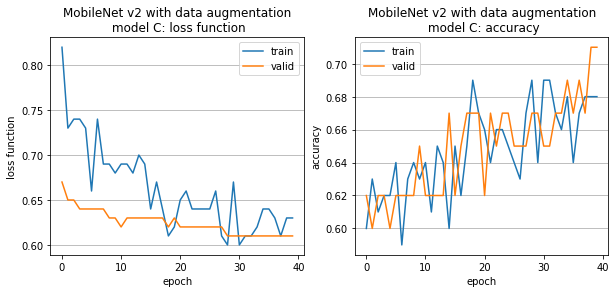

In [ ]:
mymodules.check_loss_accu('MobileNet v2 with data augmentation\n model C', history_2, figname_loss)

yes
2/2 [==============================] - 0s 34ms/step
prediction accuracy of MobileNet v2 with data augmentation
       train  valid  test
class                    
0       0.93    1.0  0.87
1       0.30    0.2  0.18


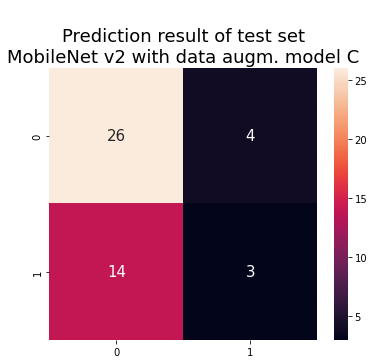

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_mobilev2_aug2, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('MobileNet v2 with data augmentation', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nMobileNet v2 with data augm. model C', fontsize=18)
plt.savefig(figname_matrix)

### 4.4.2 Inception_V3 With data augmentation

#### Model B

In [ ]:
model_inceptv3_aug1 = make_model_B(base_model_incep, N_CLASSES)
model_inceptv3_aug1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_1 = model_inceptv3_aug1.fit_generator(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_steps = valid_steps_per_epoch, 
                    validation_data = valid_generator,
                    epochs = EPOCH_PRETRAINED, 
                    verbose=0)

<ipython-input-50-2f125a895d42>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model_inceptv3_aug1.fit_generator(train_generator,


In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'Inception_v3_model_B_loss_accu_aug.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'Inception_v3_model_B_matrix_aug.png'

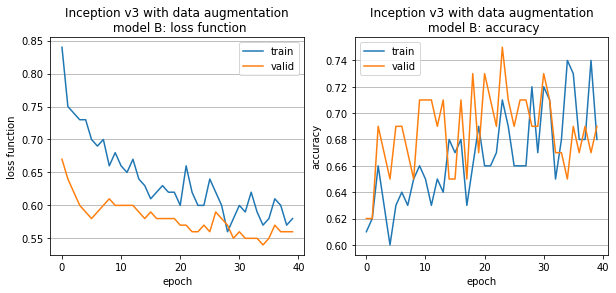

In [ ]:
mymodules.check_loss_accu('Inception v3 with data augmentation\n model B', history_1, figname_loss)

yes
2/2 [==============================] - 0s 66ms/step
prediction accuracy of Inception v3 with data augmentation
       train  valid  test
class                    
0       0.85   0.90  0.80
1       0.67   0.35  0.53


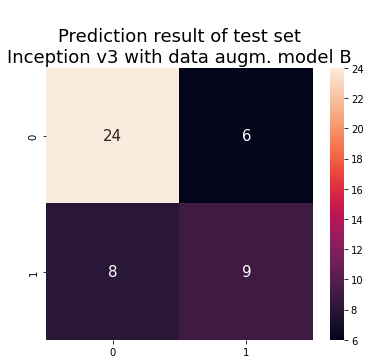

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_inceptv3_aug1, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('Inception v3 with data augmentation', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nInception v3 with data augm. model B', fontsize=18)
plt.savefig(figname_matrix)

#### Model C

In [ ]:
model_inceptv3_aug2 = make_model_C(base_model_incep, N_CLASSES)
model_inceptv3_aug2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

history_2 = model_inceptv3_aug2.fit_generator(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_steps = valid_steps_per_epoch, 
                    validation_data = valid_generator,
                    epochs = EPOCH_PRETRAINED, 
                    verbose=0)

<ipython-input-54-fe7a0544315a>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_inceptv3_aug2.fit_generator(train_generator,


In [ ]:
figname_loss = OUTPUT_FIGURE_PATH + 'Inception_v3_model_C_loss_accu_aug.png'
figname_matrix = OUTPUT_FIGURE_PATH + 'Inception_v3_model_C_matrix_aug.png'

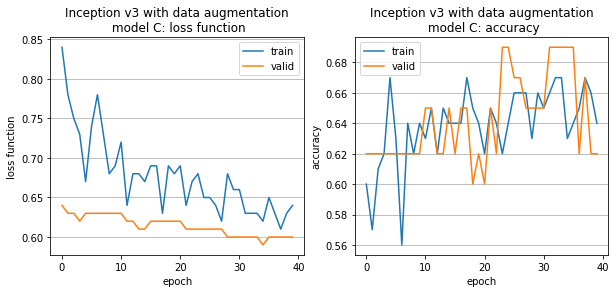

In [ ]:
mymodules.check_loss_accu('Inception v3 with data augmentation\n model C', history_2, figname_loss)

yes
2/2 [==============================] - 0s 64ms/step
prediction accuracy of Inception v3 with data augmentation
       train  valid  test
class                    
0       0.86   0.84  0.77
1       0.42   0.25  0.35


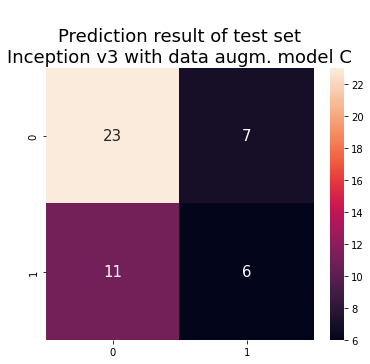

In [ ]:
pred_tr, pred_val, pred_test = mymodules.get_predict_result(model_inceptv3_aug2, X_train, X_valid, X_test, N_CLASSES)
mymodules.check_prediction_accuracy('Inception v3 with data augmentation', y_train, y_valid, y_test, pred_tr, pred_val, pred_test, N_CLASSES)
plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, annot_kws={"size":15})
plt.title('\nPrediction result of test set\nInception v3 with data augm. model C', fontsize=18)
plt.savefig(figname_matrix)